# Import the dataset
Initial import of the dataset to inspect its content and divide it into the basic components (training and test sets).

In [146]:
import numpy as np
import matplotlib as mpl
import albumentations as A
import cv2
import tensorflow as tf
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN


# Setting seeds for reproducibility
np.random.seed(20)

In [147]:
# Load the NpzFile
data = np.load("/kaggle/input/basedata/mars_for_students.npz")

# Inspect content of the NpzFile: contains two keys "training_set", "test_set"
print(data.keys())

# Extract training_set and test_set
training_set = data.get("training_set")
test_set = data.get("test_set")

# Print the shapes of both sets
print(f"The shape of the training set: {training_set.shape}")
print(f"The shape of the test set: {test_set.shape}")

# Split training set into input images and masks
input_images = training_set[:, 0, :, :]
output_masks = training_set[:, 1, :, :]

# Analyse the values of the grayscale images in the training set
print("---------------------------------------------------")
print("TRAINING SET INPUT IMAGES ANALYSIS")
print(f"The shape of the input images: {input_images.shape}")
print(f"Max pixel value: {input_images.max()}")
print(f"Min pixel value: {input_images.min()}")
print(f"Data type to encode pixel values: {input_images.dtype}")

# Analyse the values of the masks in the training set
print("---------------------------------------------------")
print("TRAINING SET OUTPUT MASKS ANALYSIS")
print(f"The shape of the output masks: {output_masks.shape}")
print(f"Max pixel value: {output_masks.max()}")
print(f"Min pixel value: {output_masks.min()}")
print(f"Data type to encode pixel values: {output_masks.dtype}")

# Analyse the values of the grayscale images in the test set
print("---------------------------------------------------")
print("TEST SET ANALYSIS")
print(f"Max pixel value: {test_set.max()}")
print(f"Min pixel value: {test_set.min()}")
print(f"Data type to encode pixel values: {test_set.dtype}")


KeysView(NpzFile '/kaggle/input/basedata/mars_for_students.npz' with keys: training_set, test_set)
The shape of the training set: (2615, 2, 64, 128)
The shape of the test set: (10022, 64, 128)
---------------------------------------------------
TRAINING SET INPUT IMAGES ANALYSIS
The shape of the input images: (2615, 64, 128)
Max pixel value: 254.0
Min pixel value: 2.0
Data type to encode pixel values: float64
---------------------------------------------------
TRAINING SET OUTPUT MASKS ANALYSIS
The shape of the output masks: (2615, 64, 128)
Max pixel value: 4.0
Min pixel value: 0.0
Data type to encode pixel values: float64
---------------------------------------------------
TEST SET ANALYSIS
Max pixel value: 255
Min pixel value: 1
Data type to encode pixel values: uint8


It is possible to notice from this initial analysis that the images have the following characteristics:

- The input images are floating point values ranging between 0 and 255 (full range, not rescaled)
- The output masks are floating point values ranging between 0 and 4 (there are 4 classes)
- The test set uses integer values instead of floats, again in the range 0 to 255

The number of samples in the training set also motivates the need for augmentation techniques, as the input images are quite limited (2615).

Since the images are in the range [0, 255], let's cast them to integer values. The same applied for masks.

In [148]:
input_images = input_images.astype(np.uint8)
output_masks = output_masks.astype(np.uint8)

# Visualisation of some images of the training set

Visualising a good amount of images from the training set can help extracting better insights into the problem to be solved.

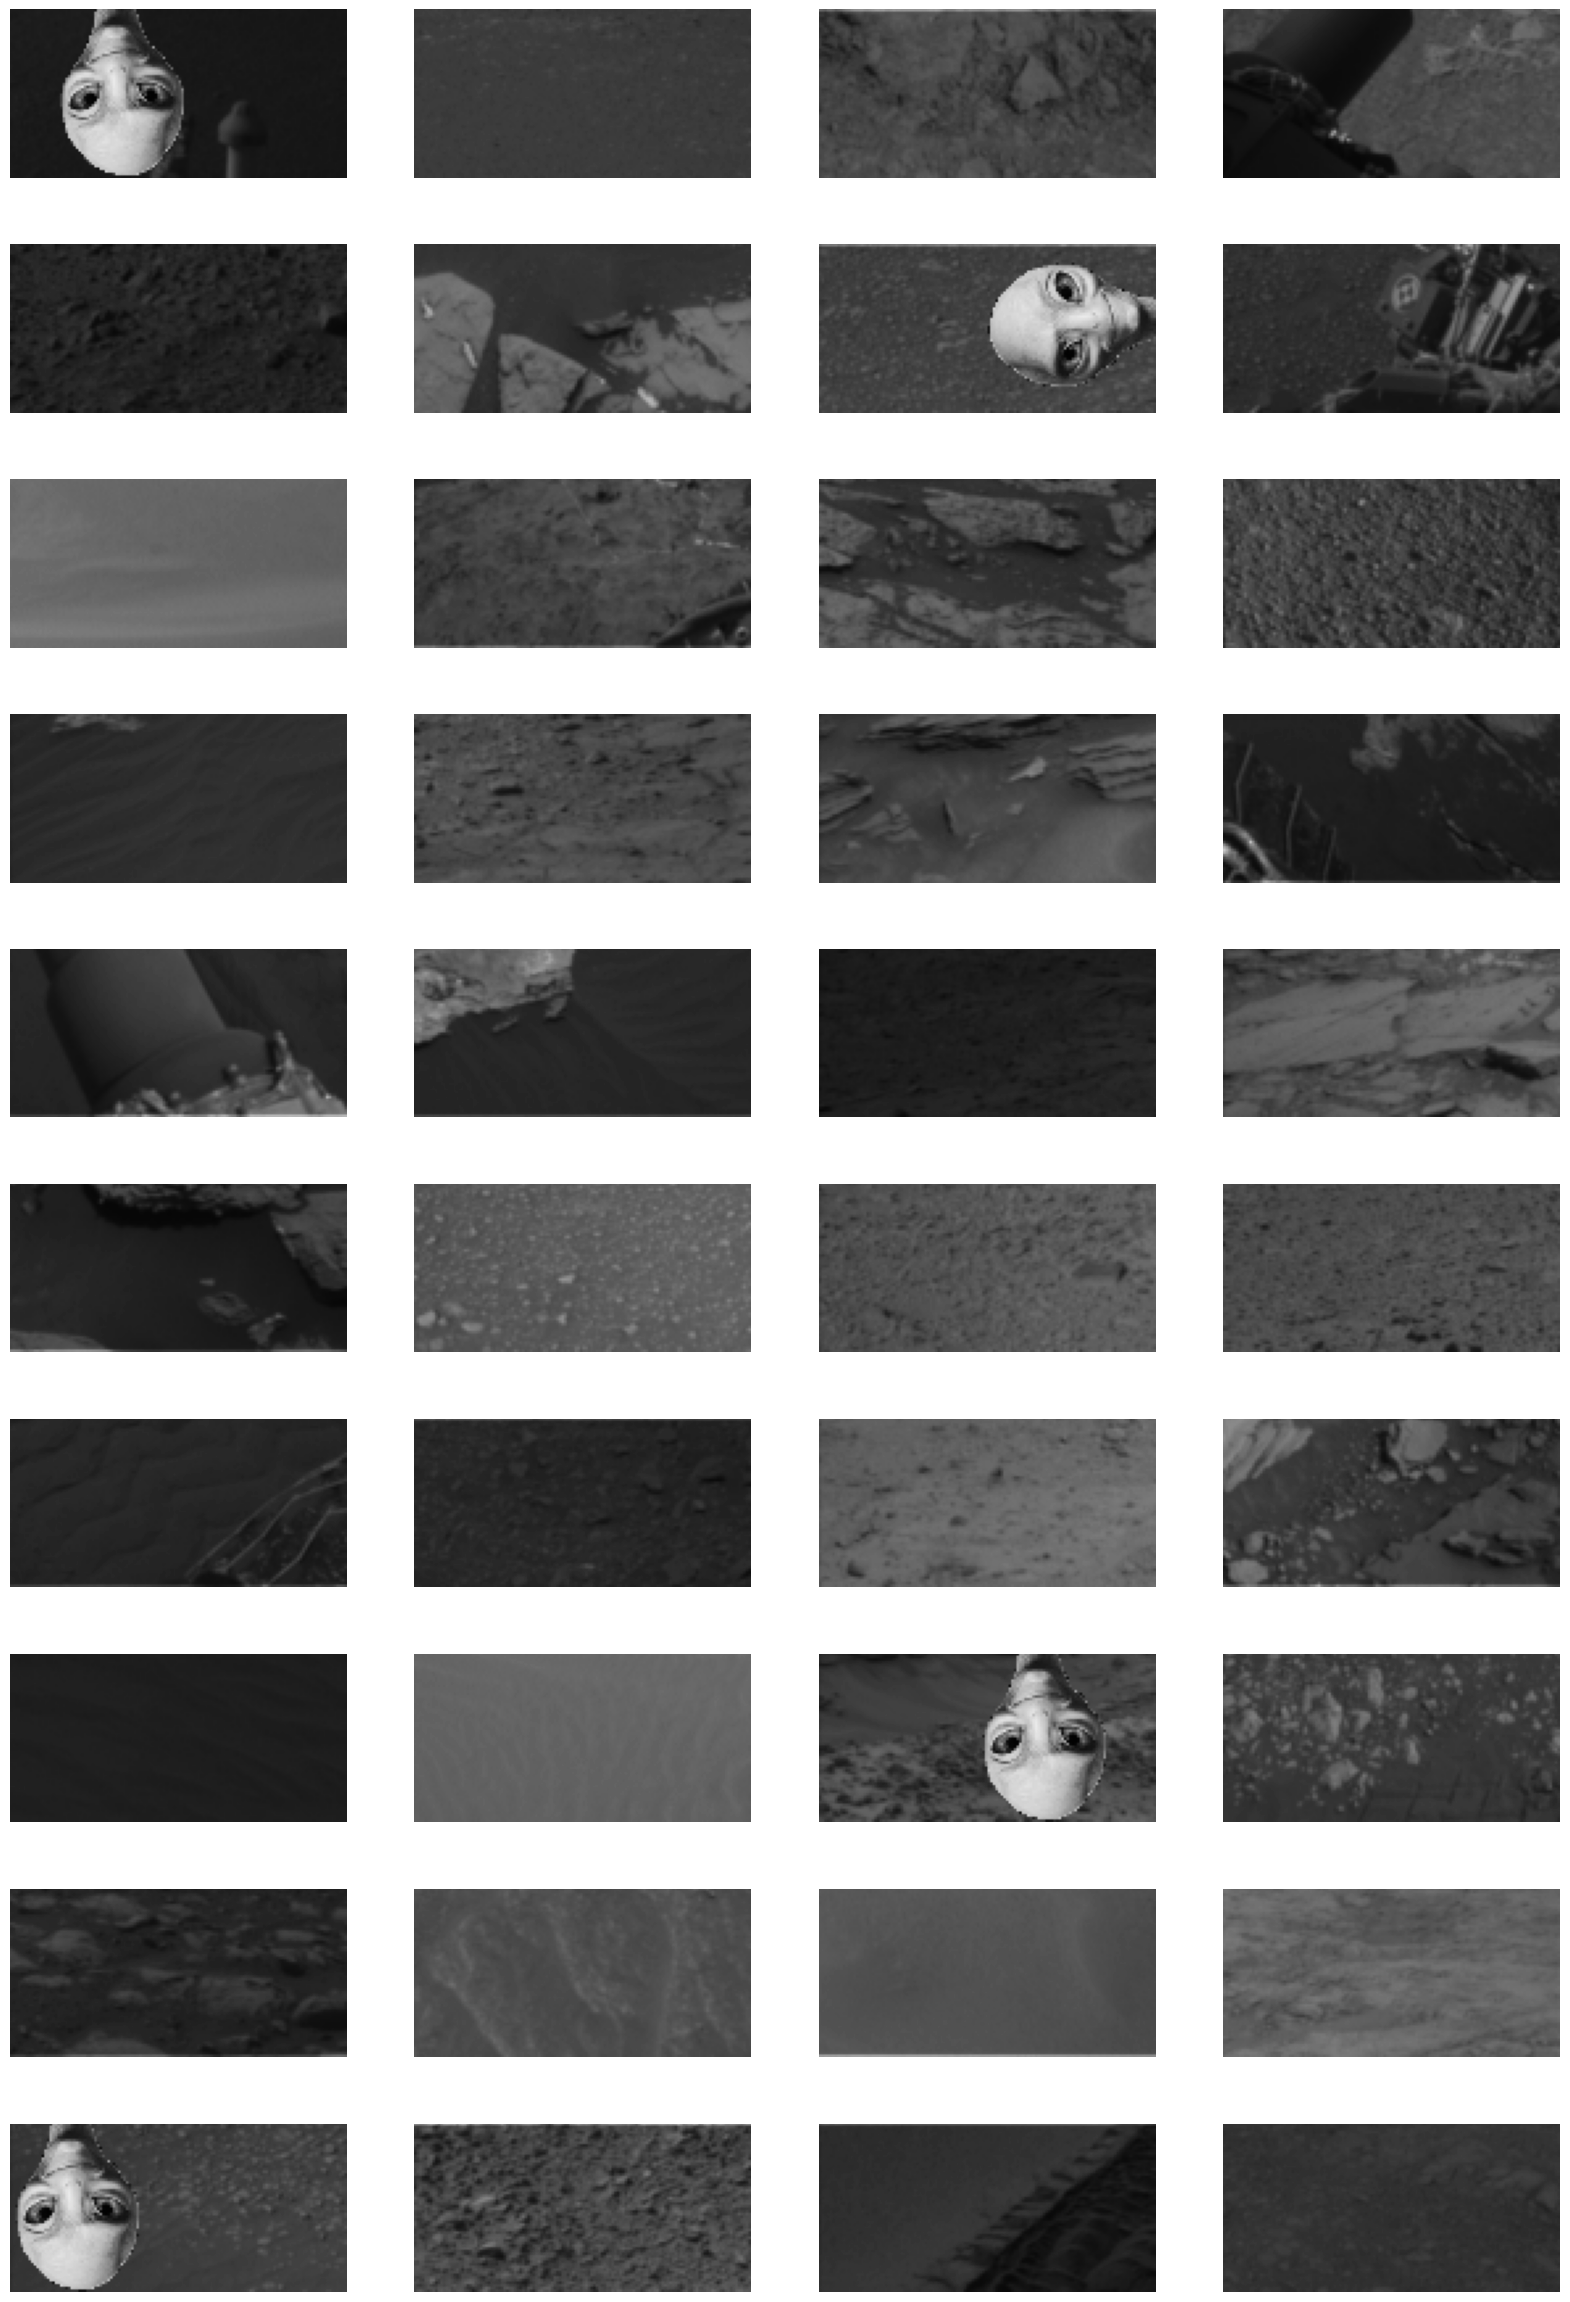

In [149]:
# Generate a new figure object
figure = mpl.pyplot.figure(figsize=(20,30))

# Create 40 subplots within the figure in a grid 10 x 4 (and flatten the Axes array)
axes_array = figure.subplots(10, 4)
axes_array = axes_array.flatten()

# Select at random 40 images from the training set and show them
random_indices = np.random.randint(0, 2614, size=40)  # Generate an array of 40 random integers
for axes, image_index in zip(axes_array, random_indices):
    axes.imshow(input_images[image_index], cmap='gray', vmin=0, vmax = 255)
    axes.axis('off')
    

figure.show()


In [150]:
# reshape x to apply PCA
x_flat = input_images.reshape(input_images.shape[0], -1)

# Reduce dimensions to 2 to plot data
pca = PCA(n_components=2)
features_pca = pca.fit_transform(x_flat)

In [151]:
pca.components_.shape

(2, 8192)

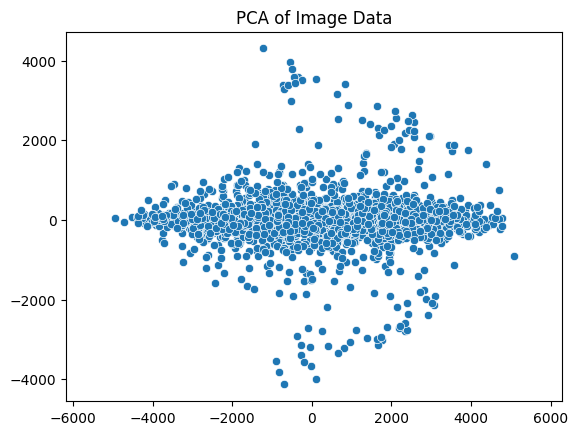

In [152]:
# Plot Principal components
plt.title('PCA of Image Data')
plt.axis('equal')
sns.scatterplot(x=features_pca[:, 0], y=features_pca[:, 1])
plt.show()

In [153]:
# Calculate euclidian distance from each sample to the origin in the PCA space
distances = np.linalg.norm(features_pca, axis=1)

# Let's find the 20 samples that are further away from the origin
num_outliers = 20
outlier_indices = np.argsort(distances)[-num_outliers:]
outlier_indices

array([1623,   93,  669,  588, 1410,  337, 1564, 1126, 1194, 2169,  504,
       2437, 1831,  258, 1739, 2614, 2089,  510, 1950, 1092])

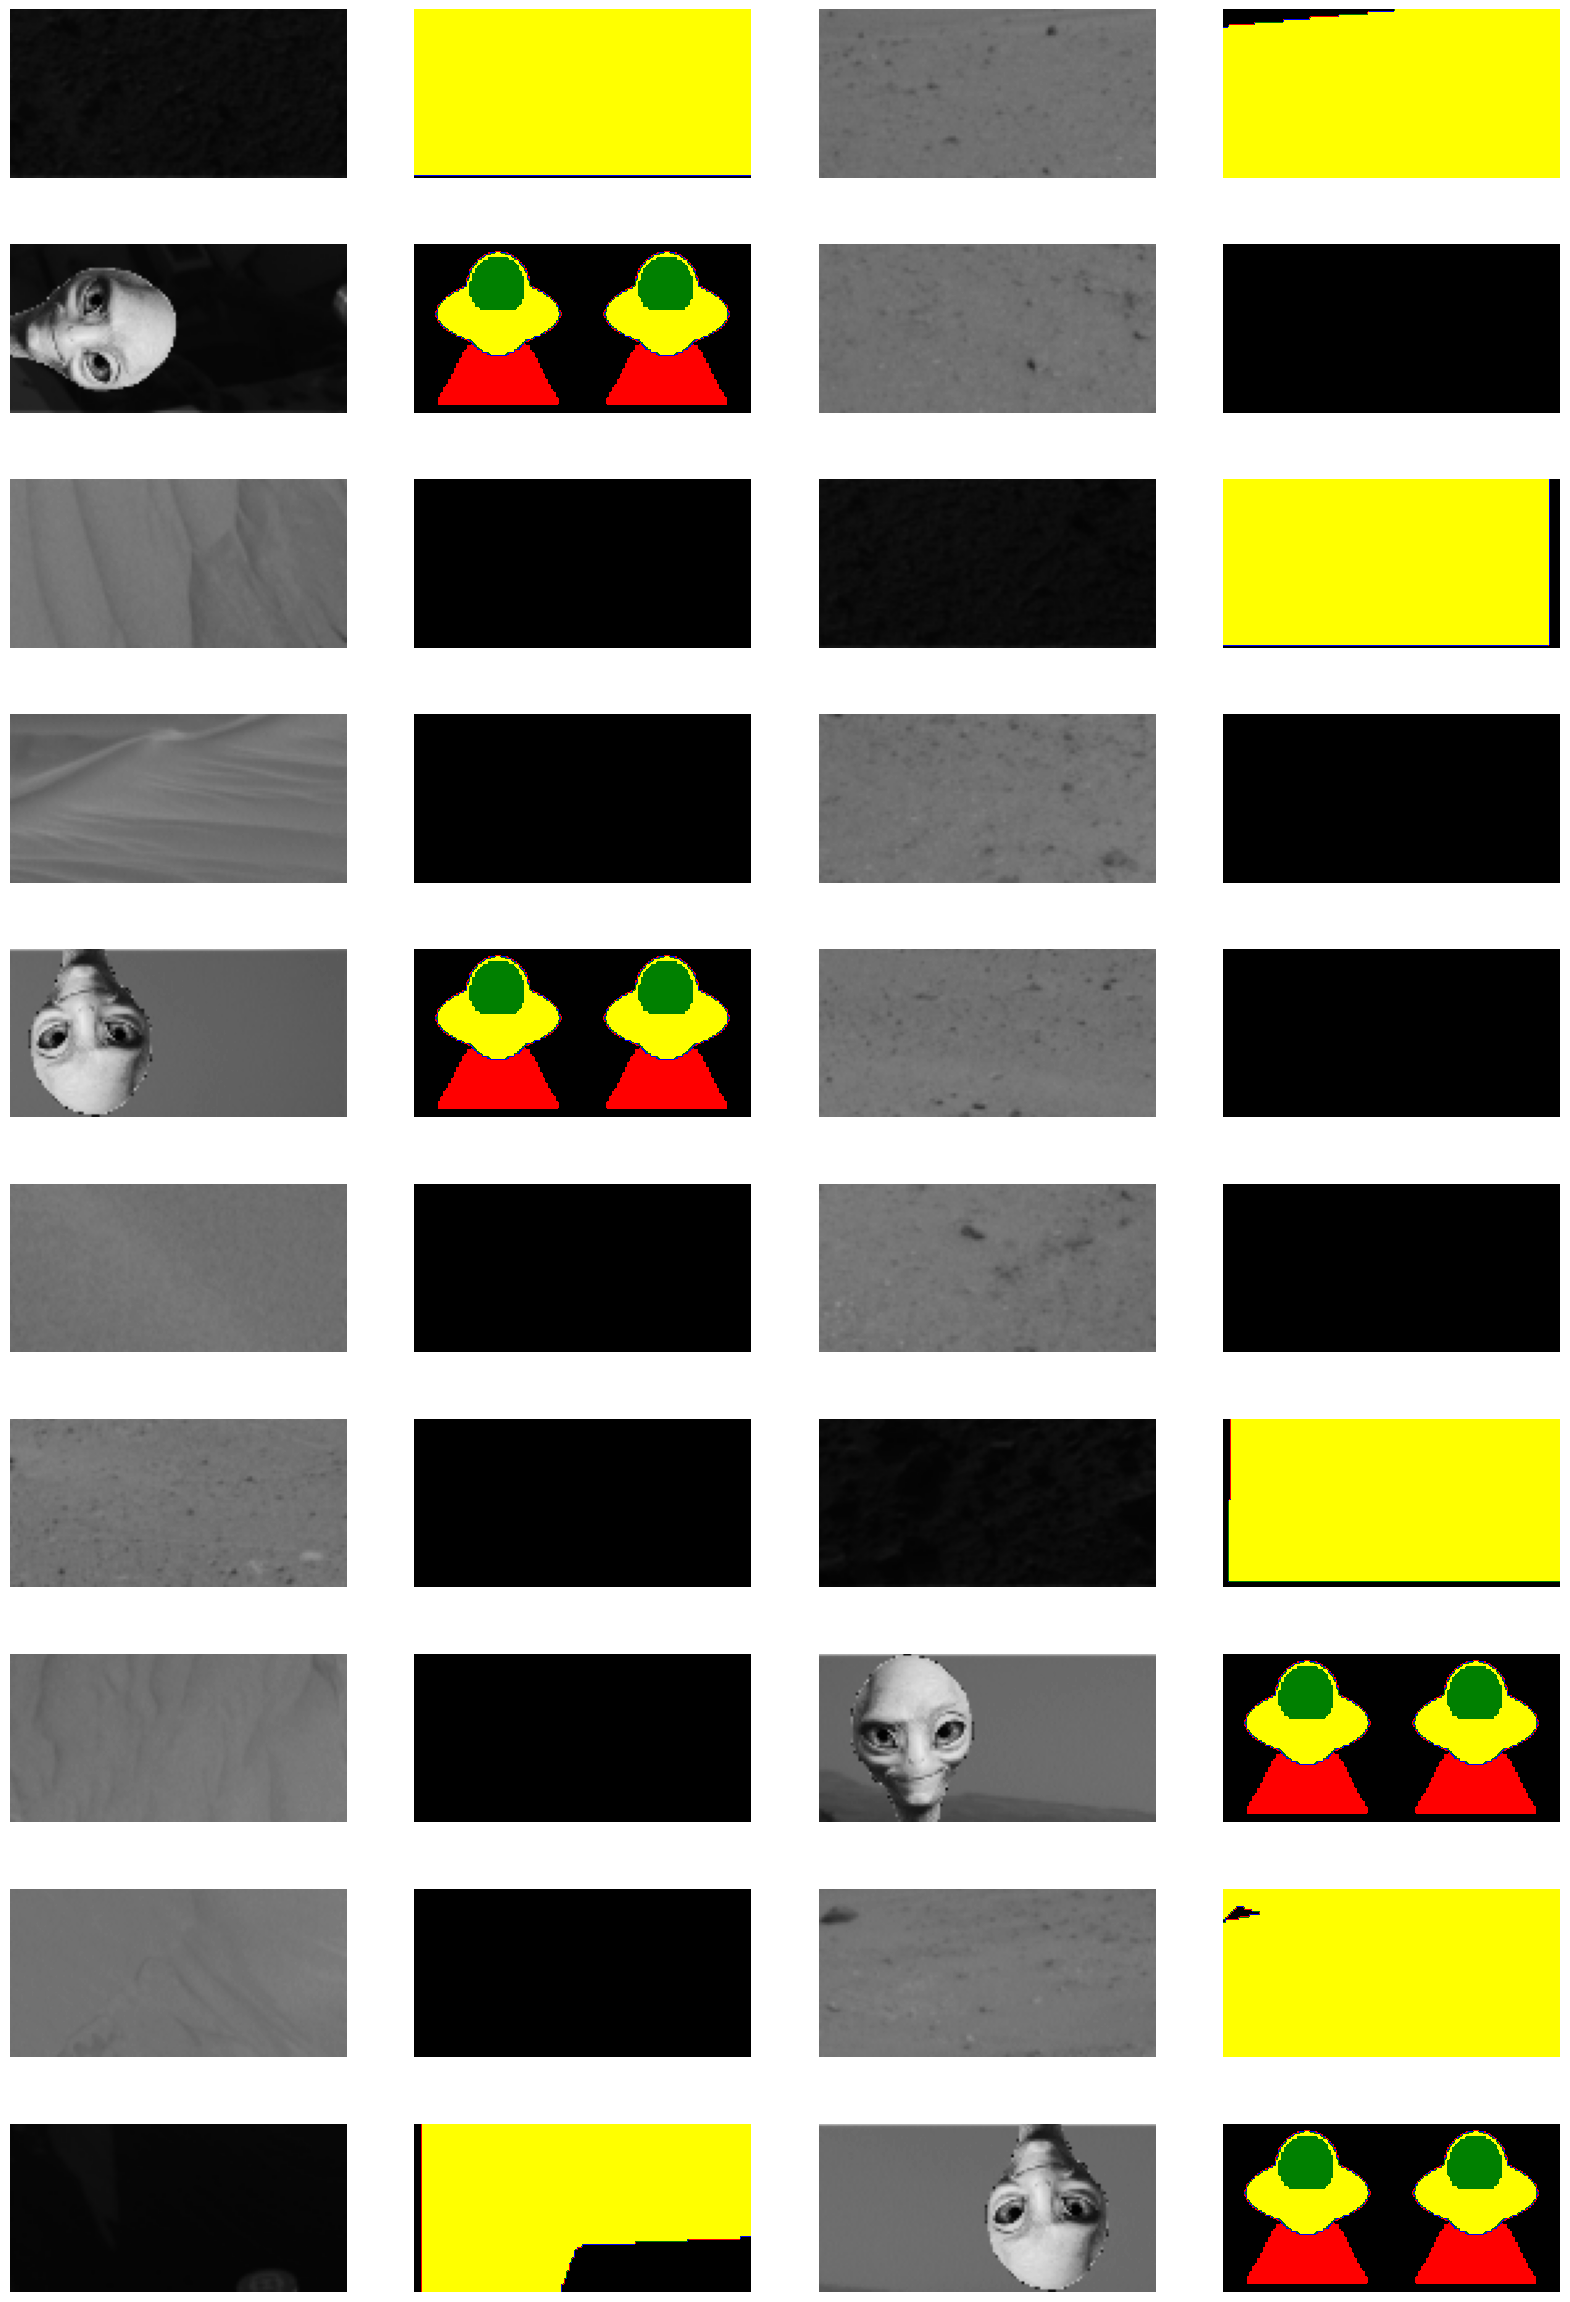

In [154]:
# Define a colormap to simplify the visualisation of the classes on the masks
# Background (0) -> black
# Soil (1) -> red
# Bedrock (2) -> blue
# Sand (3) -> green
# Big Rock (4) -> yellow
colormap = mpl.colors.ListedColormap(["black", "red", "blue", "green", "yellow"])

# Create figure
figure = mpl.pyplot.figure(figsize=(20,30))

# Create axes within the figure in a grid 10 x 4, then flatten the matrix
axes_array = figure.subplots(10, 4)
axes_array = axes_array.flatten()

# show some of these outliers
for i,index in enumerate(outlier_indices) :
    axes_array[i*2].imshow(input_images[index], cmap='gray', vmin=0, vmax=255)
    axes_array[i*2].axis('off')
    
    axes_array[i*2 + 1].imshow(output_masks[index], cmap=colormap)
    axes_array[i*2 + 1].axis('off')

In [155]:
print("Distances of the outliers:", distances[outlier_indices])
sherk_distance = round(distances[outlier_indices][-1])
sherk_distance

Distances of the outliers: [4396.8736746  4450.11101991 4476.93853019 4479.9671532  4497.77589902
 4512.41527583 4529.91560479 4561.84275123 4601.4330112  4607.58061299
 4619.88188537 4656.4206593  4692.43233332 4715.28841278 4730.18129295
 4752.13025346 4767.60216393 4775.14132066 4953.32905228 5159.57678495]


5160

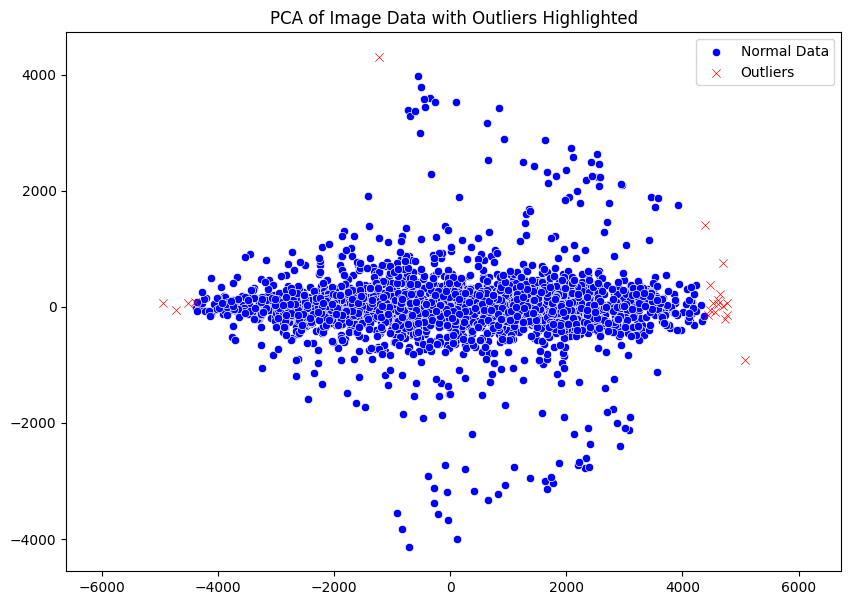

In [156]:
# Create a mask for the outliers
outlier_mask = np.zeros(features_pca.shape[0], dtype=bool)
outlier_mask[outlier_indices] = True

# Plot the PCA data
plt.figure(figsize=(10, 7))
plt.title('PCA of Image Data with Outliers Highlighted')
plt.axis('equal')

# Plot the non-outliers
sns.scatterplot(x=features_pca[~outlier_mask, 0], y=features_pca[~outlier_mask, 1], label='Normal Data', color='blue')

# Plot the outliers
sns.scatterplot(x=features_pca[outlier_mask, 0], y=features_pca[outlier_mask, 1], label='Outliers', color='red', marker='x')

# Add legend
plt.legend()
plt.show()

Maybe this is not the most appropiate method to find all the outliers in here...
Let's try DBSCAN

## First round of cleaning

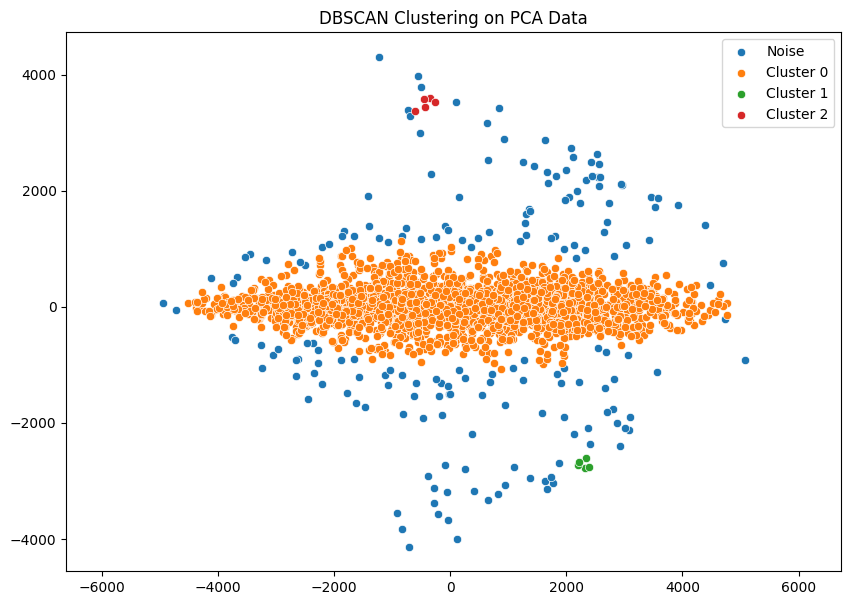

In [157]:
# Apply DBSCAN
epsilon = 200  # Radius of the neighborhood
min_samples = 5  # Minimum points required to form a cluster
dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
clusters = dbscan.fit_predict(features_pca)

# Plot the clusters
plt.figure(figsize=(10, 7))
plt.title('DBSCAN Clustering on PCA Data')
plt.axis('equal')

# Unique cluster labels
unique_clusters = np.unique(clusters)

# Plot each cluster
for cluster_label in unique_clusters:
    cluster_points = features_pca[clusters == cluster_label]
    label = f'Cluster {cluster_label}' if cluster_label != -1 else 'Noise'
    sns.scatterplot(x=cluster_points[:, 0], y=cluster_points[:, 1], label=label)

# Add legend
plt.legend()
plt.show()

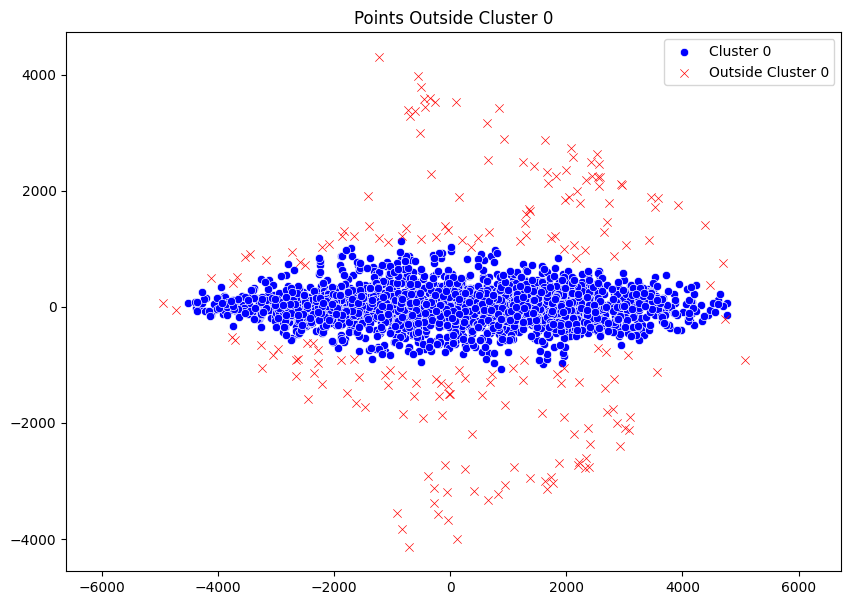

In [158]:
# Get indices of points outside of cluster 0
non_cluster_0_indices = np.where(clusters != 0)[0]

# Points outside of cluster 0
non_cluster_0_points = features_pca[non_cluster_0_indices]

# Plot all points, highlighting those not in cluster 0
plt.figure(figsize=(10, 7))
plt.title('Points Outside Cluster 0')
plt.axis('equal')

# Plot points in cluster 0
sns.scatterplot(x=features_pca[clusters == 0, 0], y=features_pca[clusters == 0, 1], label='Cluster 0', color='blue')

# Plot points outside of cluster 0
sns.scatterplot(x=non_cluster_0_points[:, 0], y=non_cluster_0_points[:, 1], label='Outside Cluster 0', color='red', marker='x')

# Add legend
plt.legend()
plt.show()

In [159]:
non_cluster_0_points.shape

(195, 2)

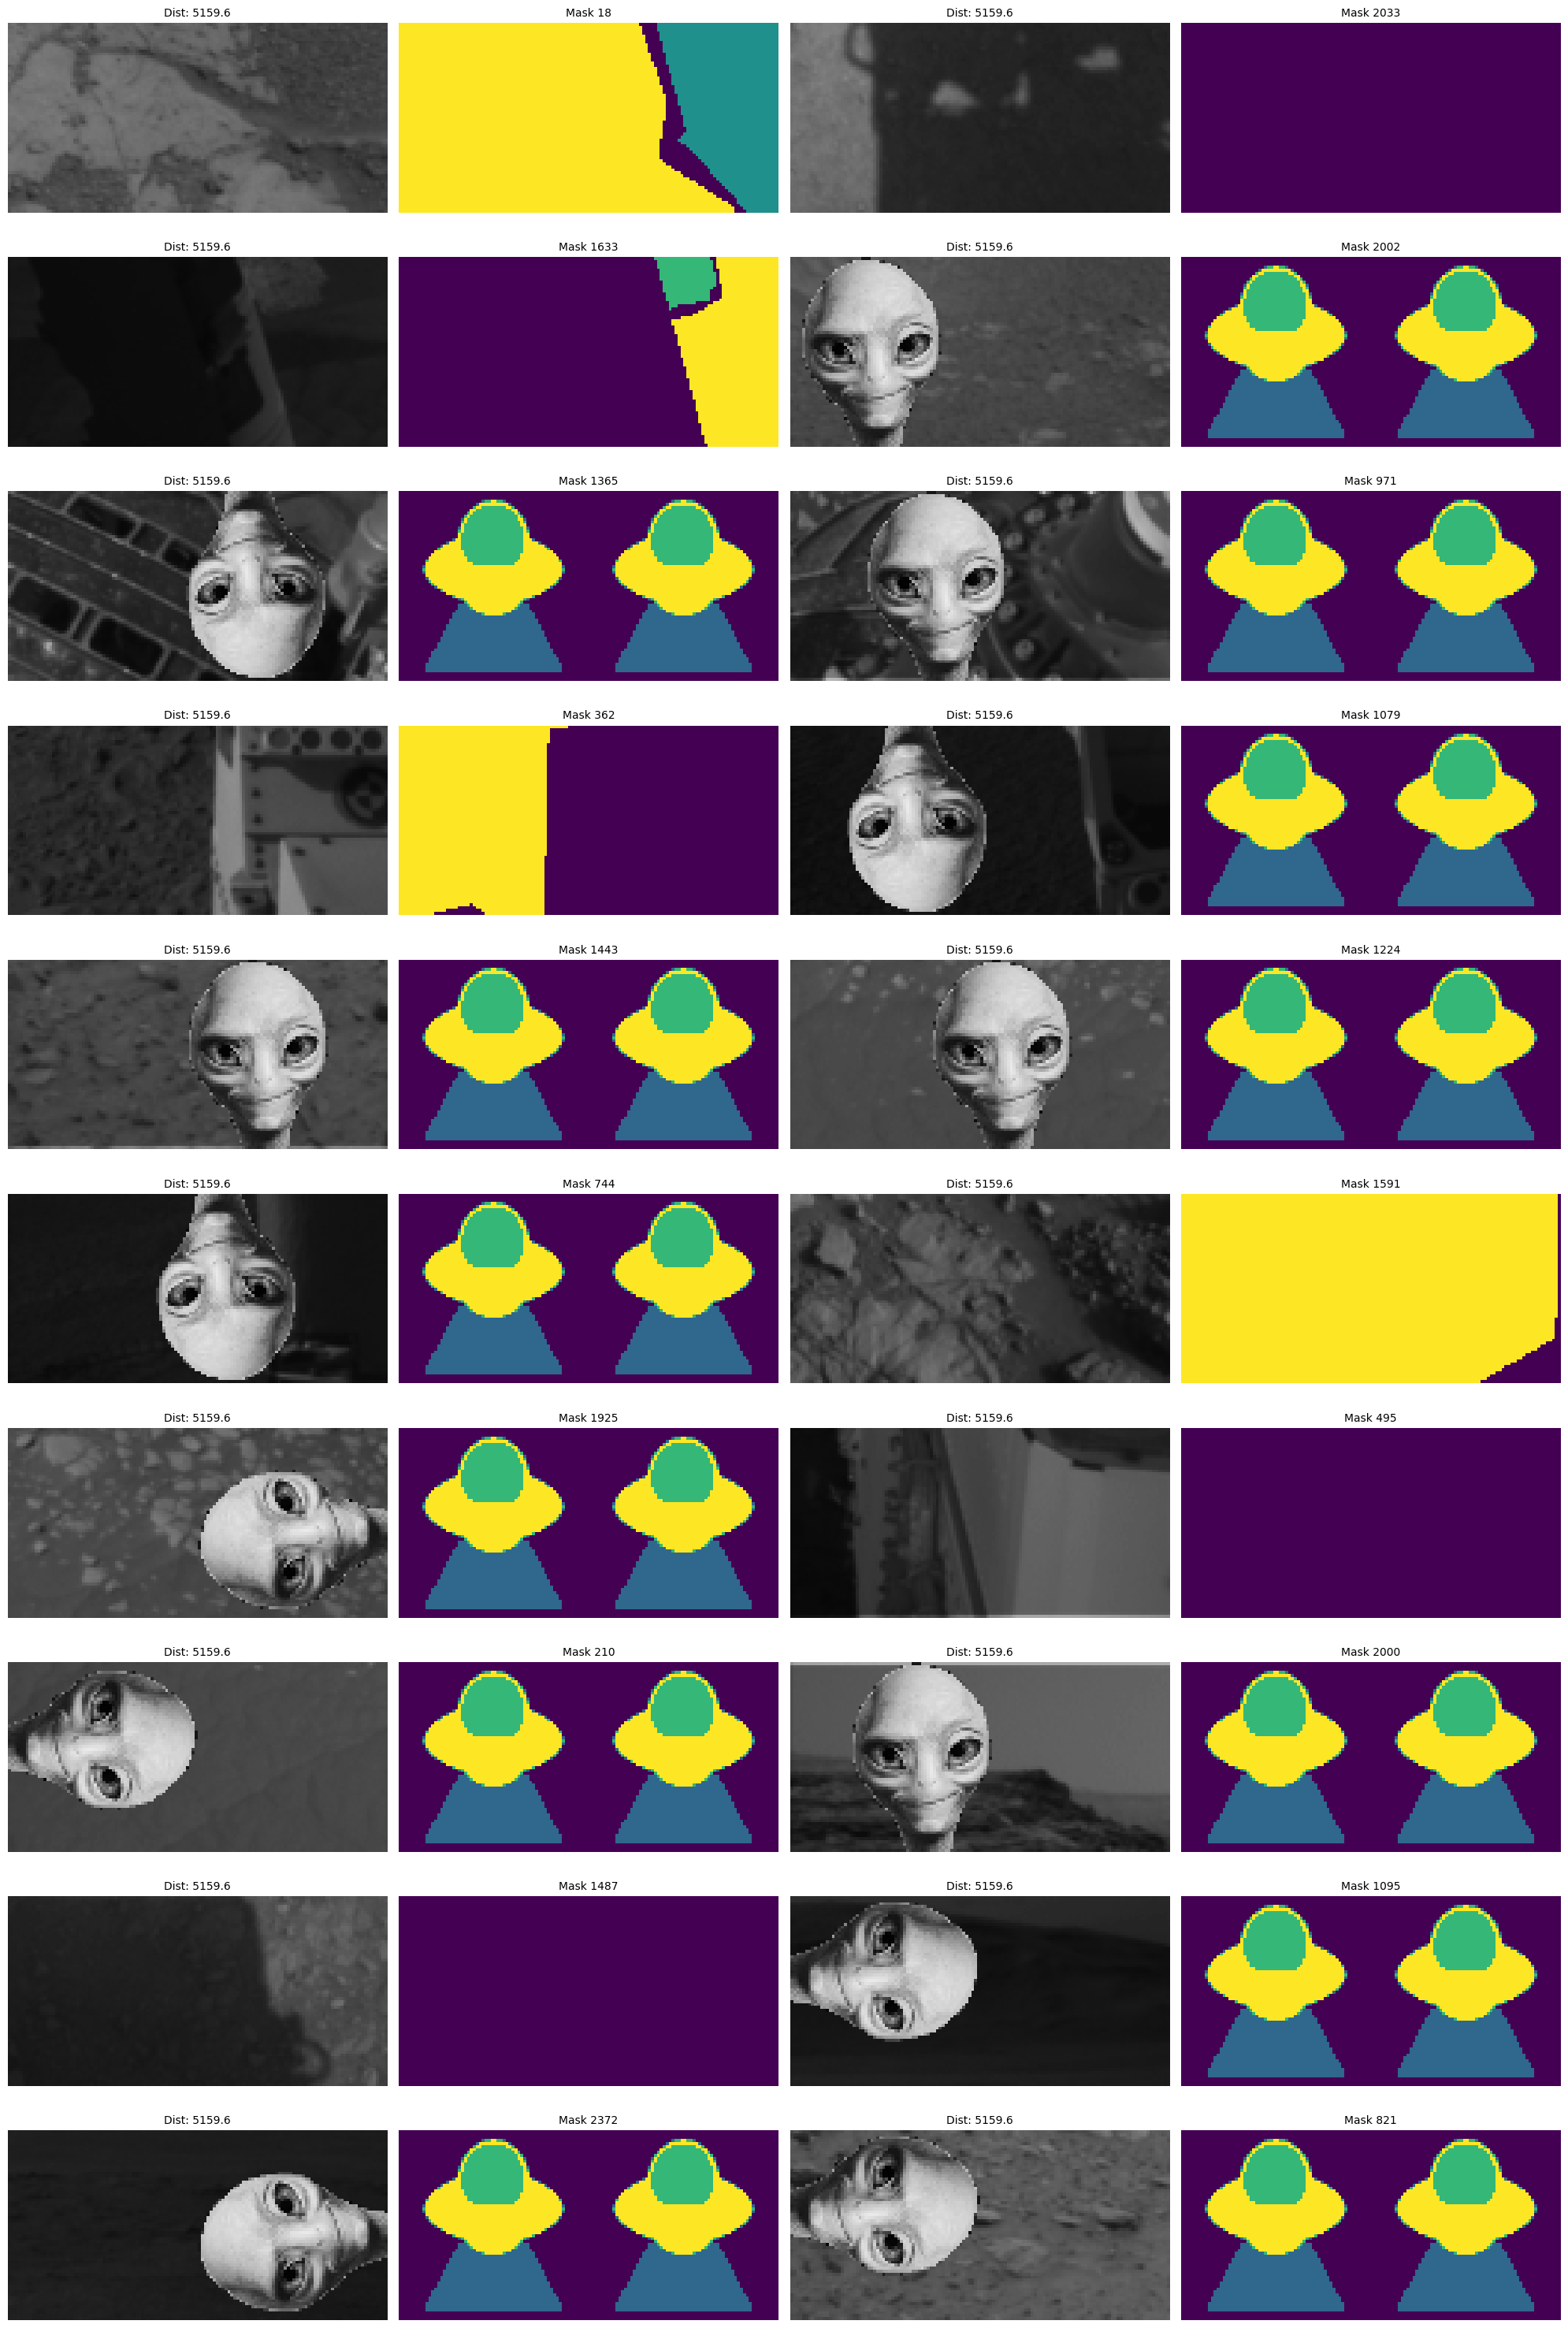

In [160]:
# Select 20 random indices from these points
random_indices = np.random.choice(non_cluster_0_indices, size=20, replace=False)

# Create a figure to display the images and masks
figure = plt.figure(figsize=(20, 30))

# Create a grid for the figure: 10 rows x 4 columns, then flatten the axes
axes_array = figure.subplots(10, 4)
axes_array = axes_array.flatten()

# Loop through the selected indices and display the images and masks
for i, index in enumerate(random_indices):
    # Display the input image
    axes_array[i * 2].imshow(input_images[index], cmap='gray', vmin=0, vmax=255)
    axes_array[i * 2].axis('off')
    axes_array[i * 2].set_title(f'Dist: {round(distances[idx], 1)}', fontsize=10)
    
    # Display the corresponding mask
    axes_array[i * 2 + 1].imshow(output_masks[index], cmap='viridis')
    axes_array[i * 2 + 1].axis('off')
    axes_array[i * 2 + 1].set_title(f'Mask {index}', fontsize=10)

plt.tight_layout()
plt.show()

As you can see most of these images are either the alien guy or poorly tagged images

In [161]:
# keep only the clean samples from x and y
input_images_clean = np.delete(input_images, non_cluster_0_indices, axis=0)
output_masks_clean = np.delete(output_masks, non_cluster_0_indices, axis=0)

input_images_clean.shape, output_masks_clean.shape

((2420, 64, 128), (2420, 64, 128))

## Second round of cleaning

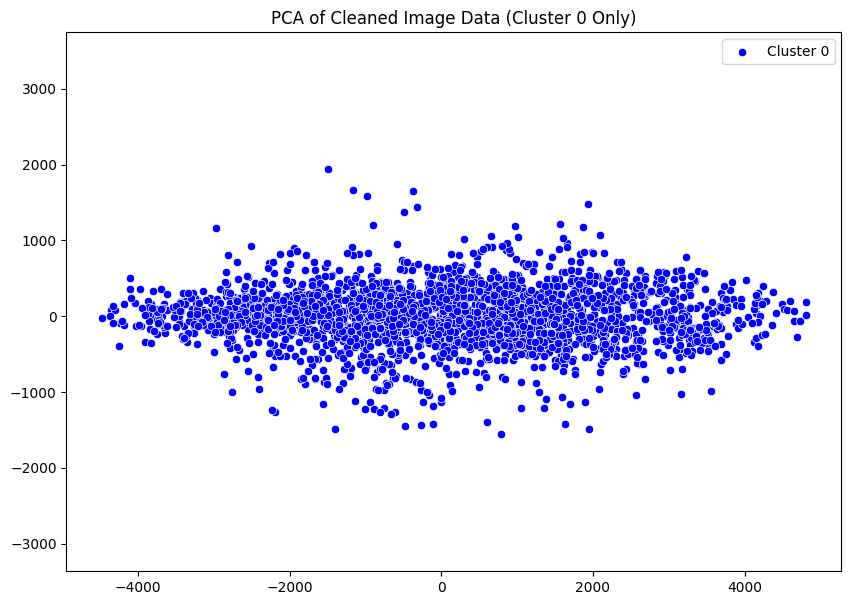

In [162]:
# Recompute PCA on the cleaned data
x_flat_clean = input_images_clean.reshape(input_images_clean.shape[0], -1)
features_pca_clean = pca.fit_transform(x_flat_clean)

# Plot the PCA result for the cleaned dataset
plt.figure(figsize=(10, 7))
plt.title('PCA of Cleaned Image Data (Cluster 0 Only)')
plt.axis('equal')

sns.scatterplot(x=features_pca_clean[:, 0], y=features_pca_clean[:, 1], label='Cluster 0', color='blue')

# Add legend
plt.legend()
plt.show()

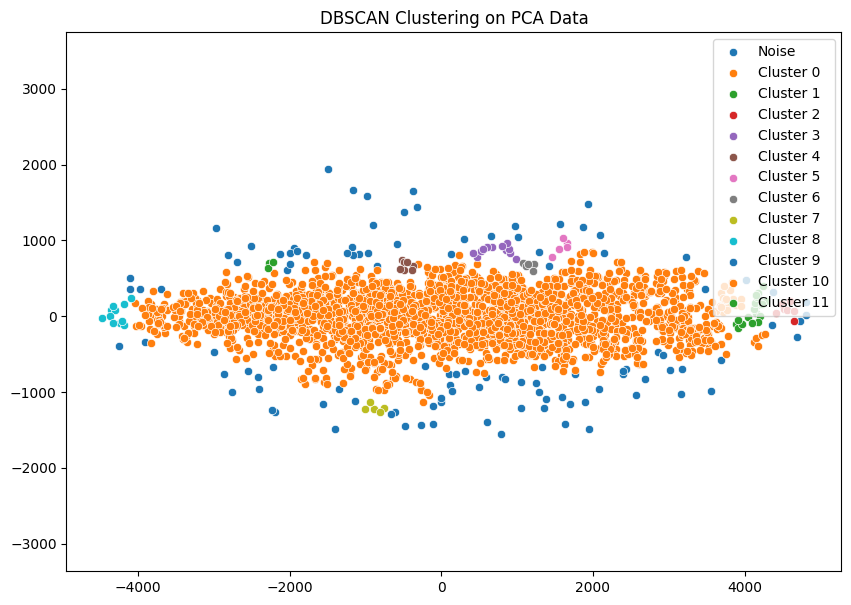

In [163]:
# Apply DBSCAN
epsilon = 150  # Radius of the neighborhood
min_samples = 5  # Minimum points required to form a cluster
dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
clusters = dbscan.fit_predict(features_pca_clean)

# Plot the clusters
plt.figure(figsize=(10, 7))
plt.title('DBSCAN Clustering on PCA Data')
plt.axis('equal')

# Unique cluster labels
unique_clusters = np.unique(clusters)

# Plot each cluster
for cluster_label in unique_clusters:
    cluster_points = features_pca_clean[clusters == cluster_label]
    label = f'Cluster {cluster_label}' if cluster_label != -1 else 'Noise'
    sns.scatterplot(x=cluster_points[:, 0], y=cluster_points[:, 1], label=label)

# Add legend
plt.legend()
plt.show()

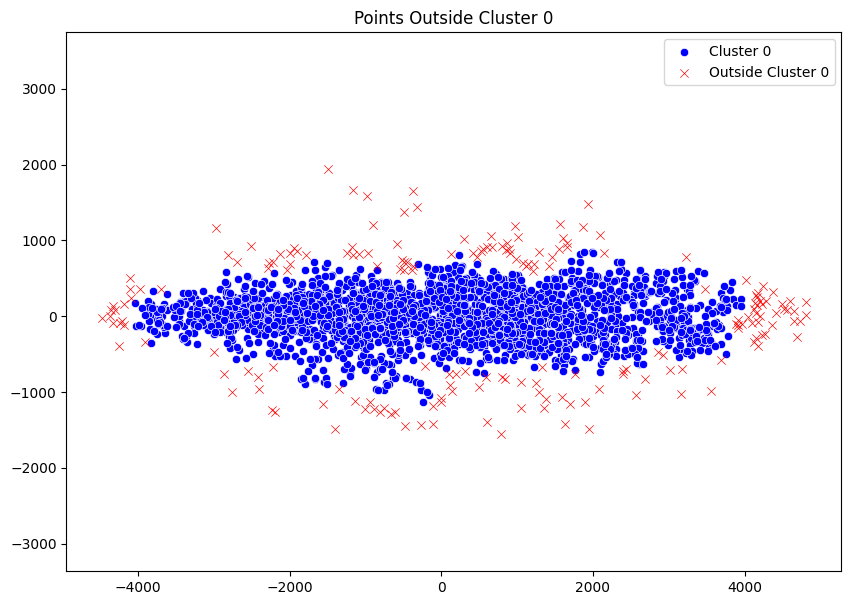

In [164]:
# Get indices of points outside of cluster 0
non_cluster_0_indices = np.where(clusters != 0)[0]

# Points outside of cluster 0
non_cluster_0_points = features_pca_clean[non_cluster_0_indices]

# Plot all points, highlighting those not in cluster 0
plt.figure(figsize=(10, 7))
plt.title('Points Outside Cluster 0')
plt.axis('equal')

# Plot points in cluster 0
sns.scatterplot(x=features_pca_clean[clusters == 0, 0], y=features_pca_clean[clusters == 0, 1], label='Cluster 0', color='blue')

# Plot points outside of cluster 0
sns.scatterplot(x=non_cluster_0_points[:, 0], y=non_cluster_0_points[:, 1], label='Outside Cluster 0', color='red', marker='x')

# Add legend
plt.legend()
plt.show()

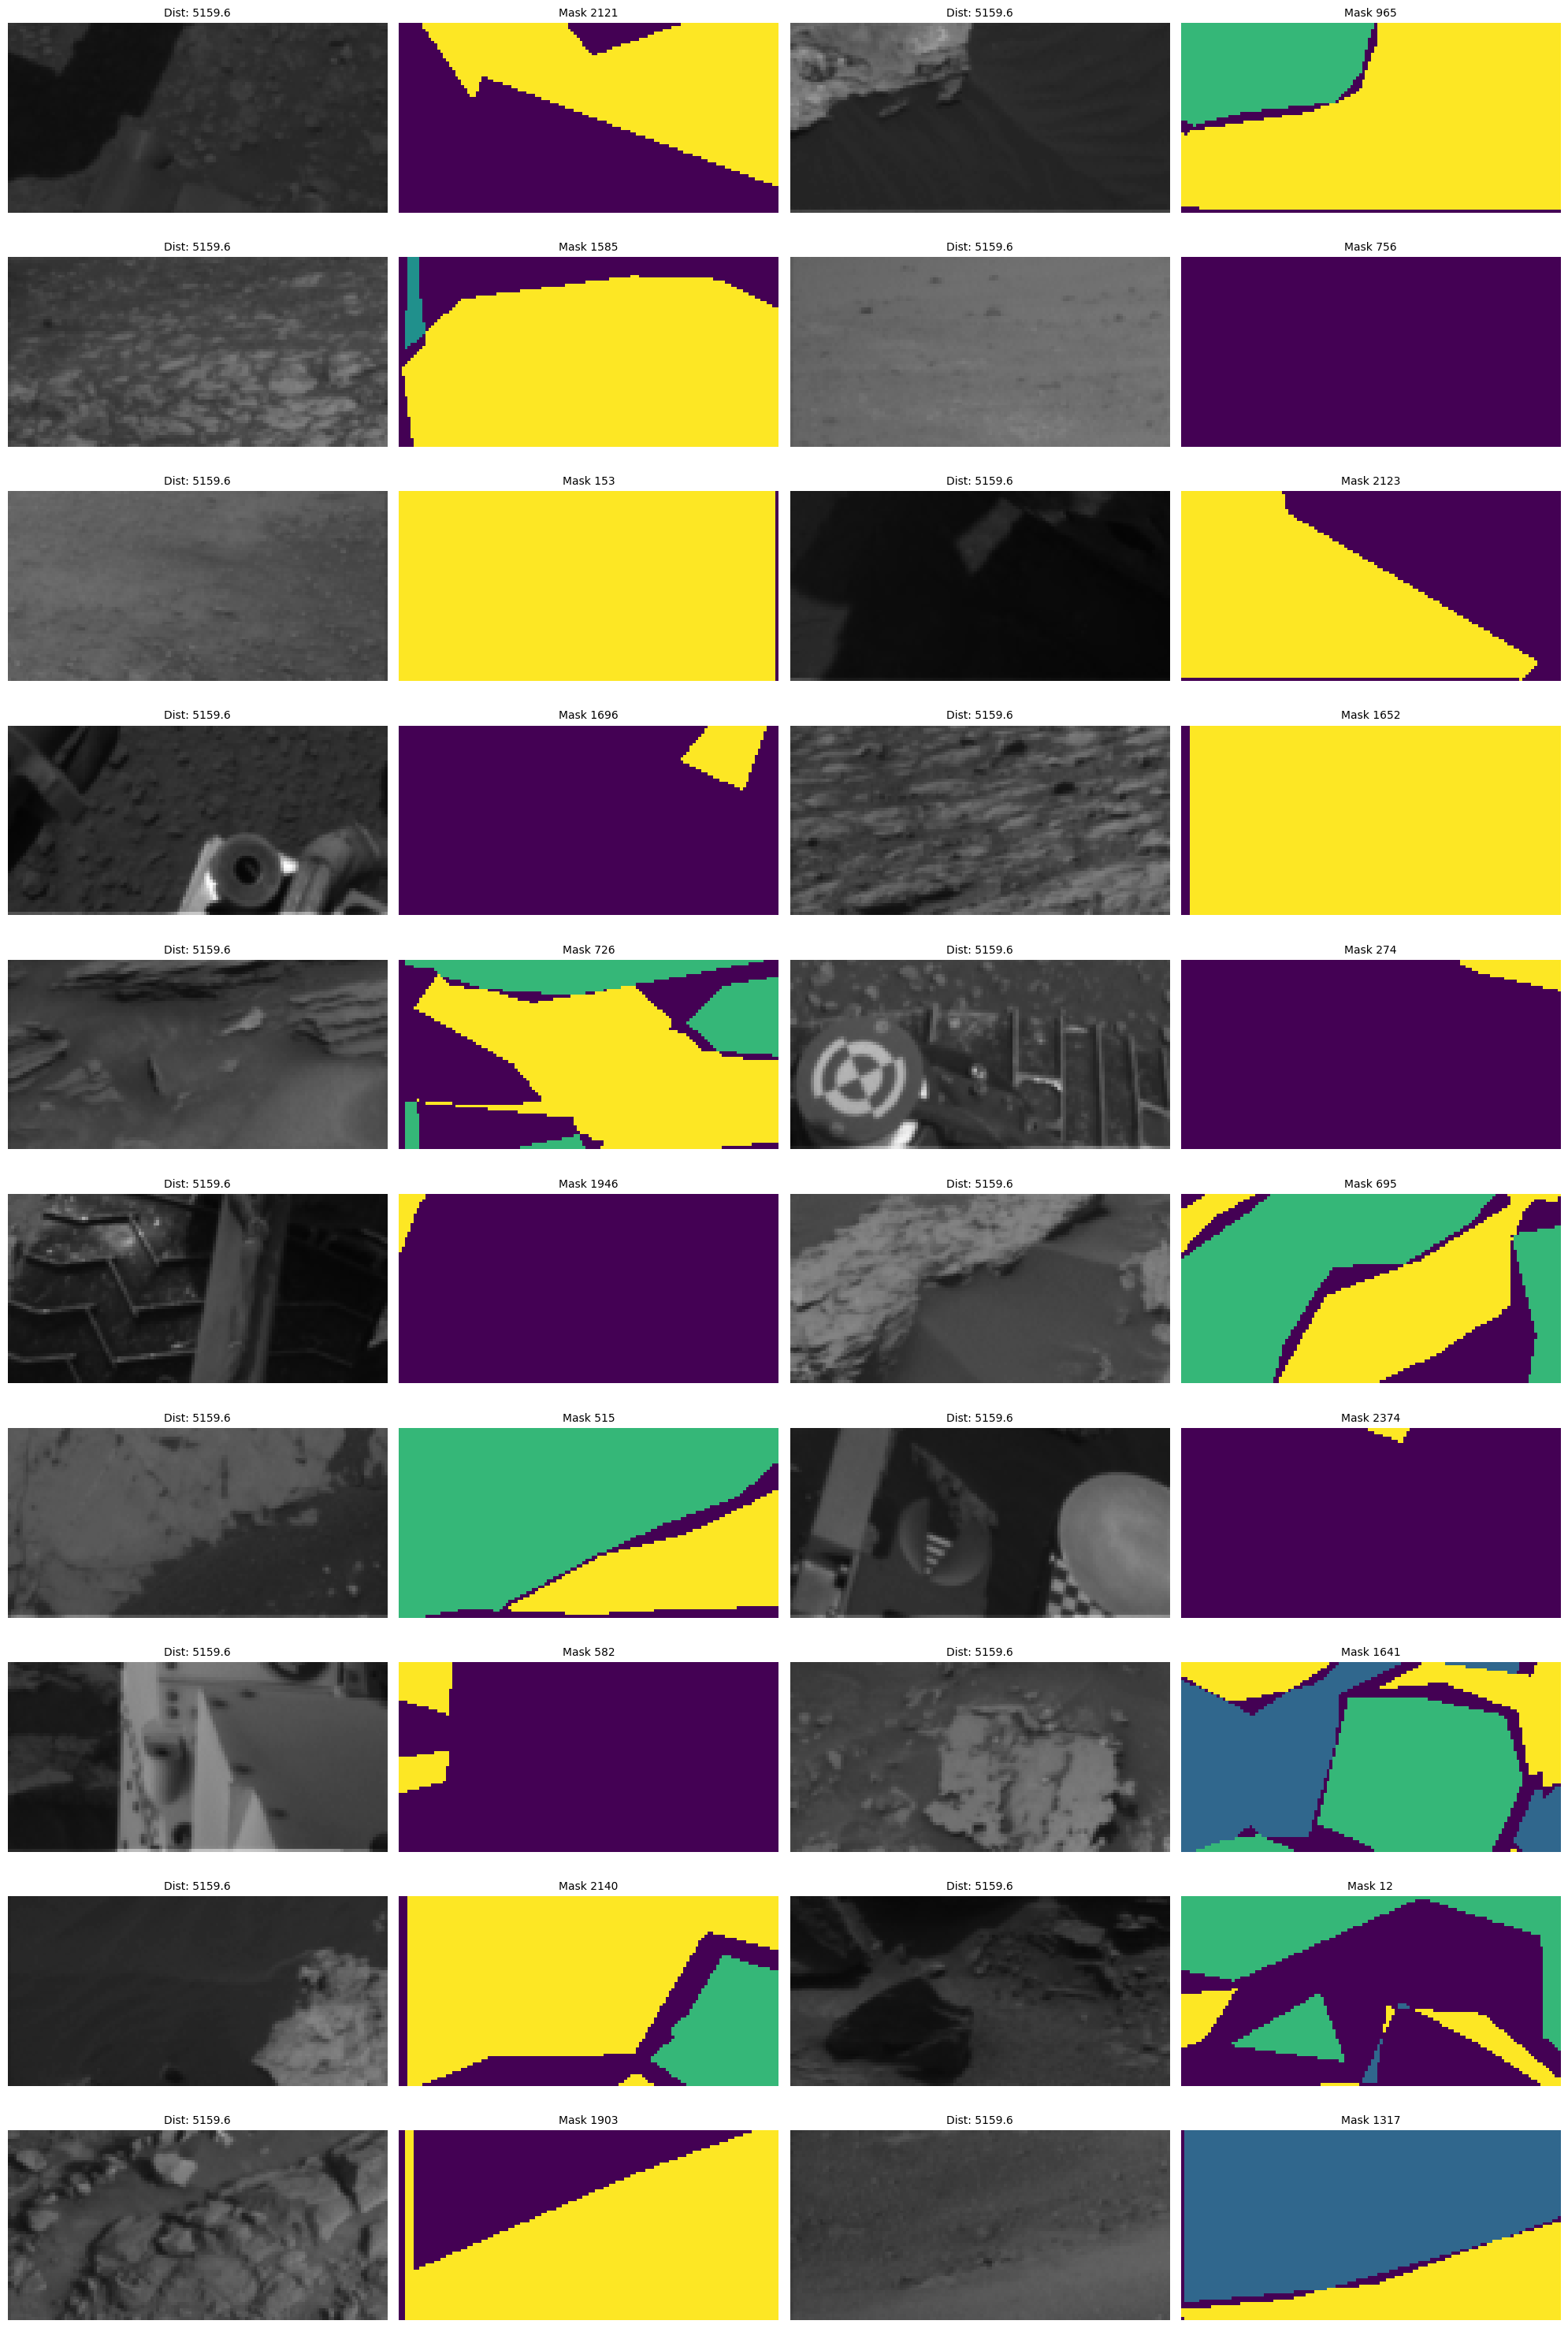

In [165]:
# Select 20 random indices from these points
random_indices = np.random.choice(non_cluster_0_indices, size=20, replace=False)

# Create a figure to display the images and masks
figure = plt.figure(figsize=(20, 30))

# Create a grid for the figure: 10 rows x 4 columns, then flatten the axes
axes_array = figure.subplots(10, 4)
axes_array = axes_array.flatten()

# Loop through the selected indices and display the images and masks
for i, index in enumerate(random_indices):
    # Display the input image
    axes_array[i * 2].imshow(input_images_clean[index], cmap='gray', vmin=0, vmax=255)
    axes_array[i * 2].axis('off')
    axes_array[i * 2].set_title(f'Dist: {round(distances[idx], 1)}', fontsize=10)
    
    # Display the corresponding mask
    axes_array[i * 2 + 1].imshow(output_masks_clean[index], cmap='viridis')
    axes_array[i * 2 + 1].axis('off')
    axes_array[i * 2 + 1].set_title(f'Mask {index}', fontsize=10)

plt.tight_layout()
plt.show()

There's still poorly labeled data in the dataset, so we'll do another shredding of the dataset

In [166]:
# keep only the clean samples from x and y
input_images_clean = np.delete(input_images_clean, non_cluster_0_indices, axis=0)
output_masks_clean = np.delete(output_masks_clean, non_cluster_0_indices, axis=0)

input_images_clean.shape, output_masks_clean.shape

((2229, 64, 128), (2229, 64, 128))

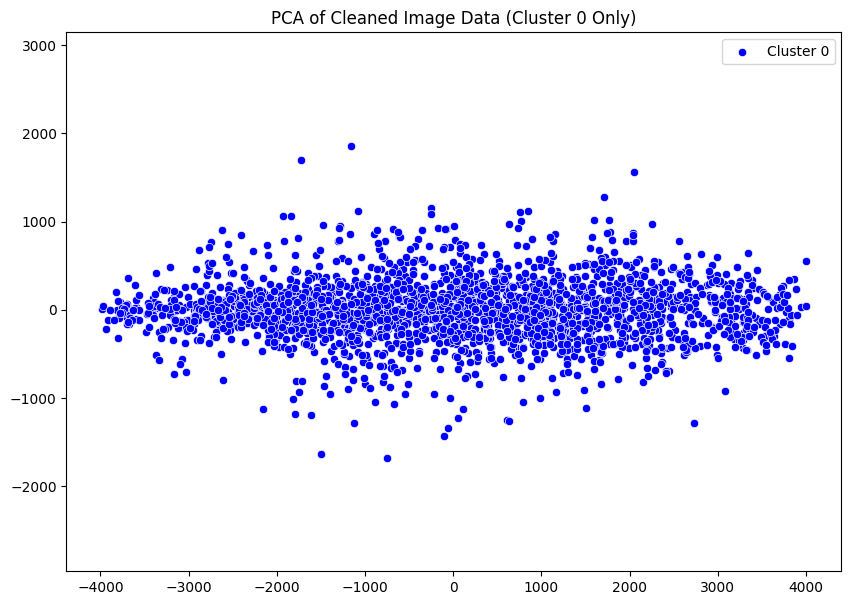

In [167]:
# Recompute PCA on the cleaned data
x_flat_clean = input_images_clean.reshape(input_images_clean.shape[0], -1)
features_pca_clean = pca.fit_transform(x_flat_clean)

# Plot the PCA result for the cleaned dataset
plt.figure(figsize=(10, 7))
plt.title('PCA of Cleaned Image Data (Cluster 0 Only)')
plt.axis('equal')

sns.scatterplot(x=features_pca_clean[:, 0], y=features_pca_clean[:, 1], label='Cluster 0', color='blue')

# Add legend
plt.legend()
plt.show()

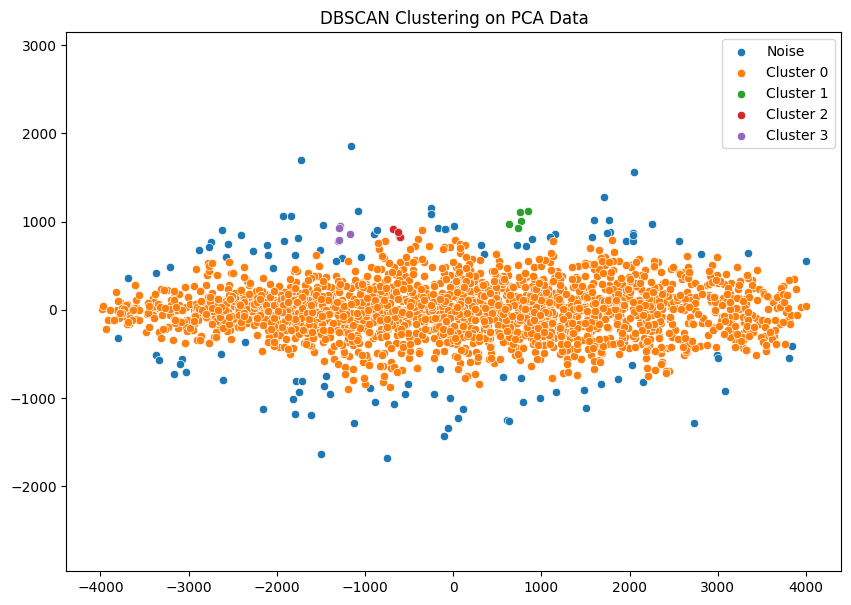

In [168]:
# Apply DBSCAN
epsilon = 150  # Radius of the neighborhood
min_samples = 5  # Minimum points required to form a cluster
dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
clusters = dbscan.fit_predict(features_pca_clean)

# Plot the clusters
plt.figure(figsize=(10, 7))
plt.title('DBSCAN Clustering on PCA Data')
plt.axis('equal')

# Unique cluster labels
unique_clusters = np.unique(clusters)

# Plot each cluster
for cluster_label in unique_clusters:
    cluster_points = features_pca_clean[clusters == cluster_label]
    label = f'Cluster {cluster_label}' if cluster_label != -1 else 'Noise'
    sns.scatterplot(x=cluster_points[:, 0], y=cluster_points[:, 1], label=label)

# Add legend
plt.legend()
plt.show()

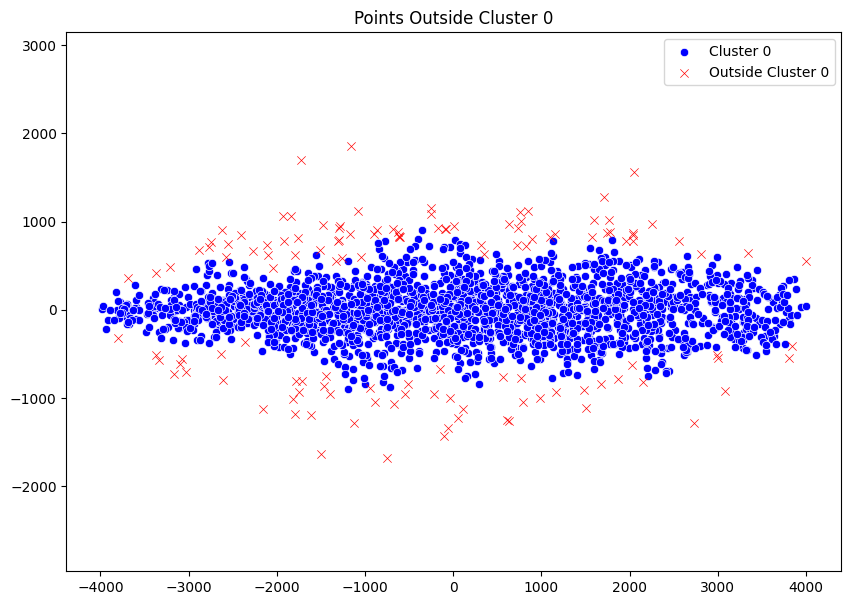

In [169]:
# Get indices of points outside of cluster 0
non_cluster_0_indices = np.where(clusters != 0)[0]

# Points outside of cluster 0
non_cluster_0_points = features_pca_clean[non_cluster_0_indices]

# Plot all points, highlighting those not in cluster 0
plt.figure(figsize=(10, 7))
plt.title('Points Outside Cluster 0')
plt.axis('equal')

# Plot points in cluster 0
sns.scatterplot(x=features_pca_clean[clusters == 0, 0], y=features_pca_clean[clusters == 0, 1], label='Cluster 0', color='blue')

# Plot points outside of cluster 0
sns.scatterplot(x=non_cluster_0_points[:, 0], y=non_cluster_0_points[:, 1], label='Outside Cluster 0', color='red', marker='x')

# Add legend
plt.legend()
plt.show()

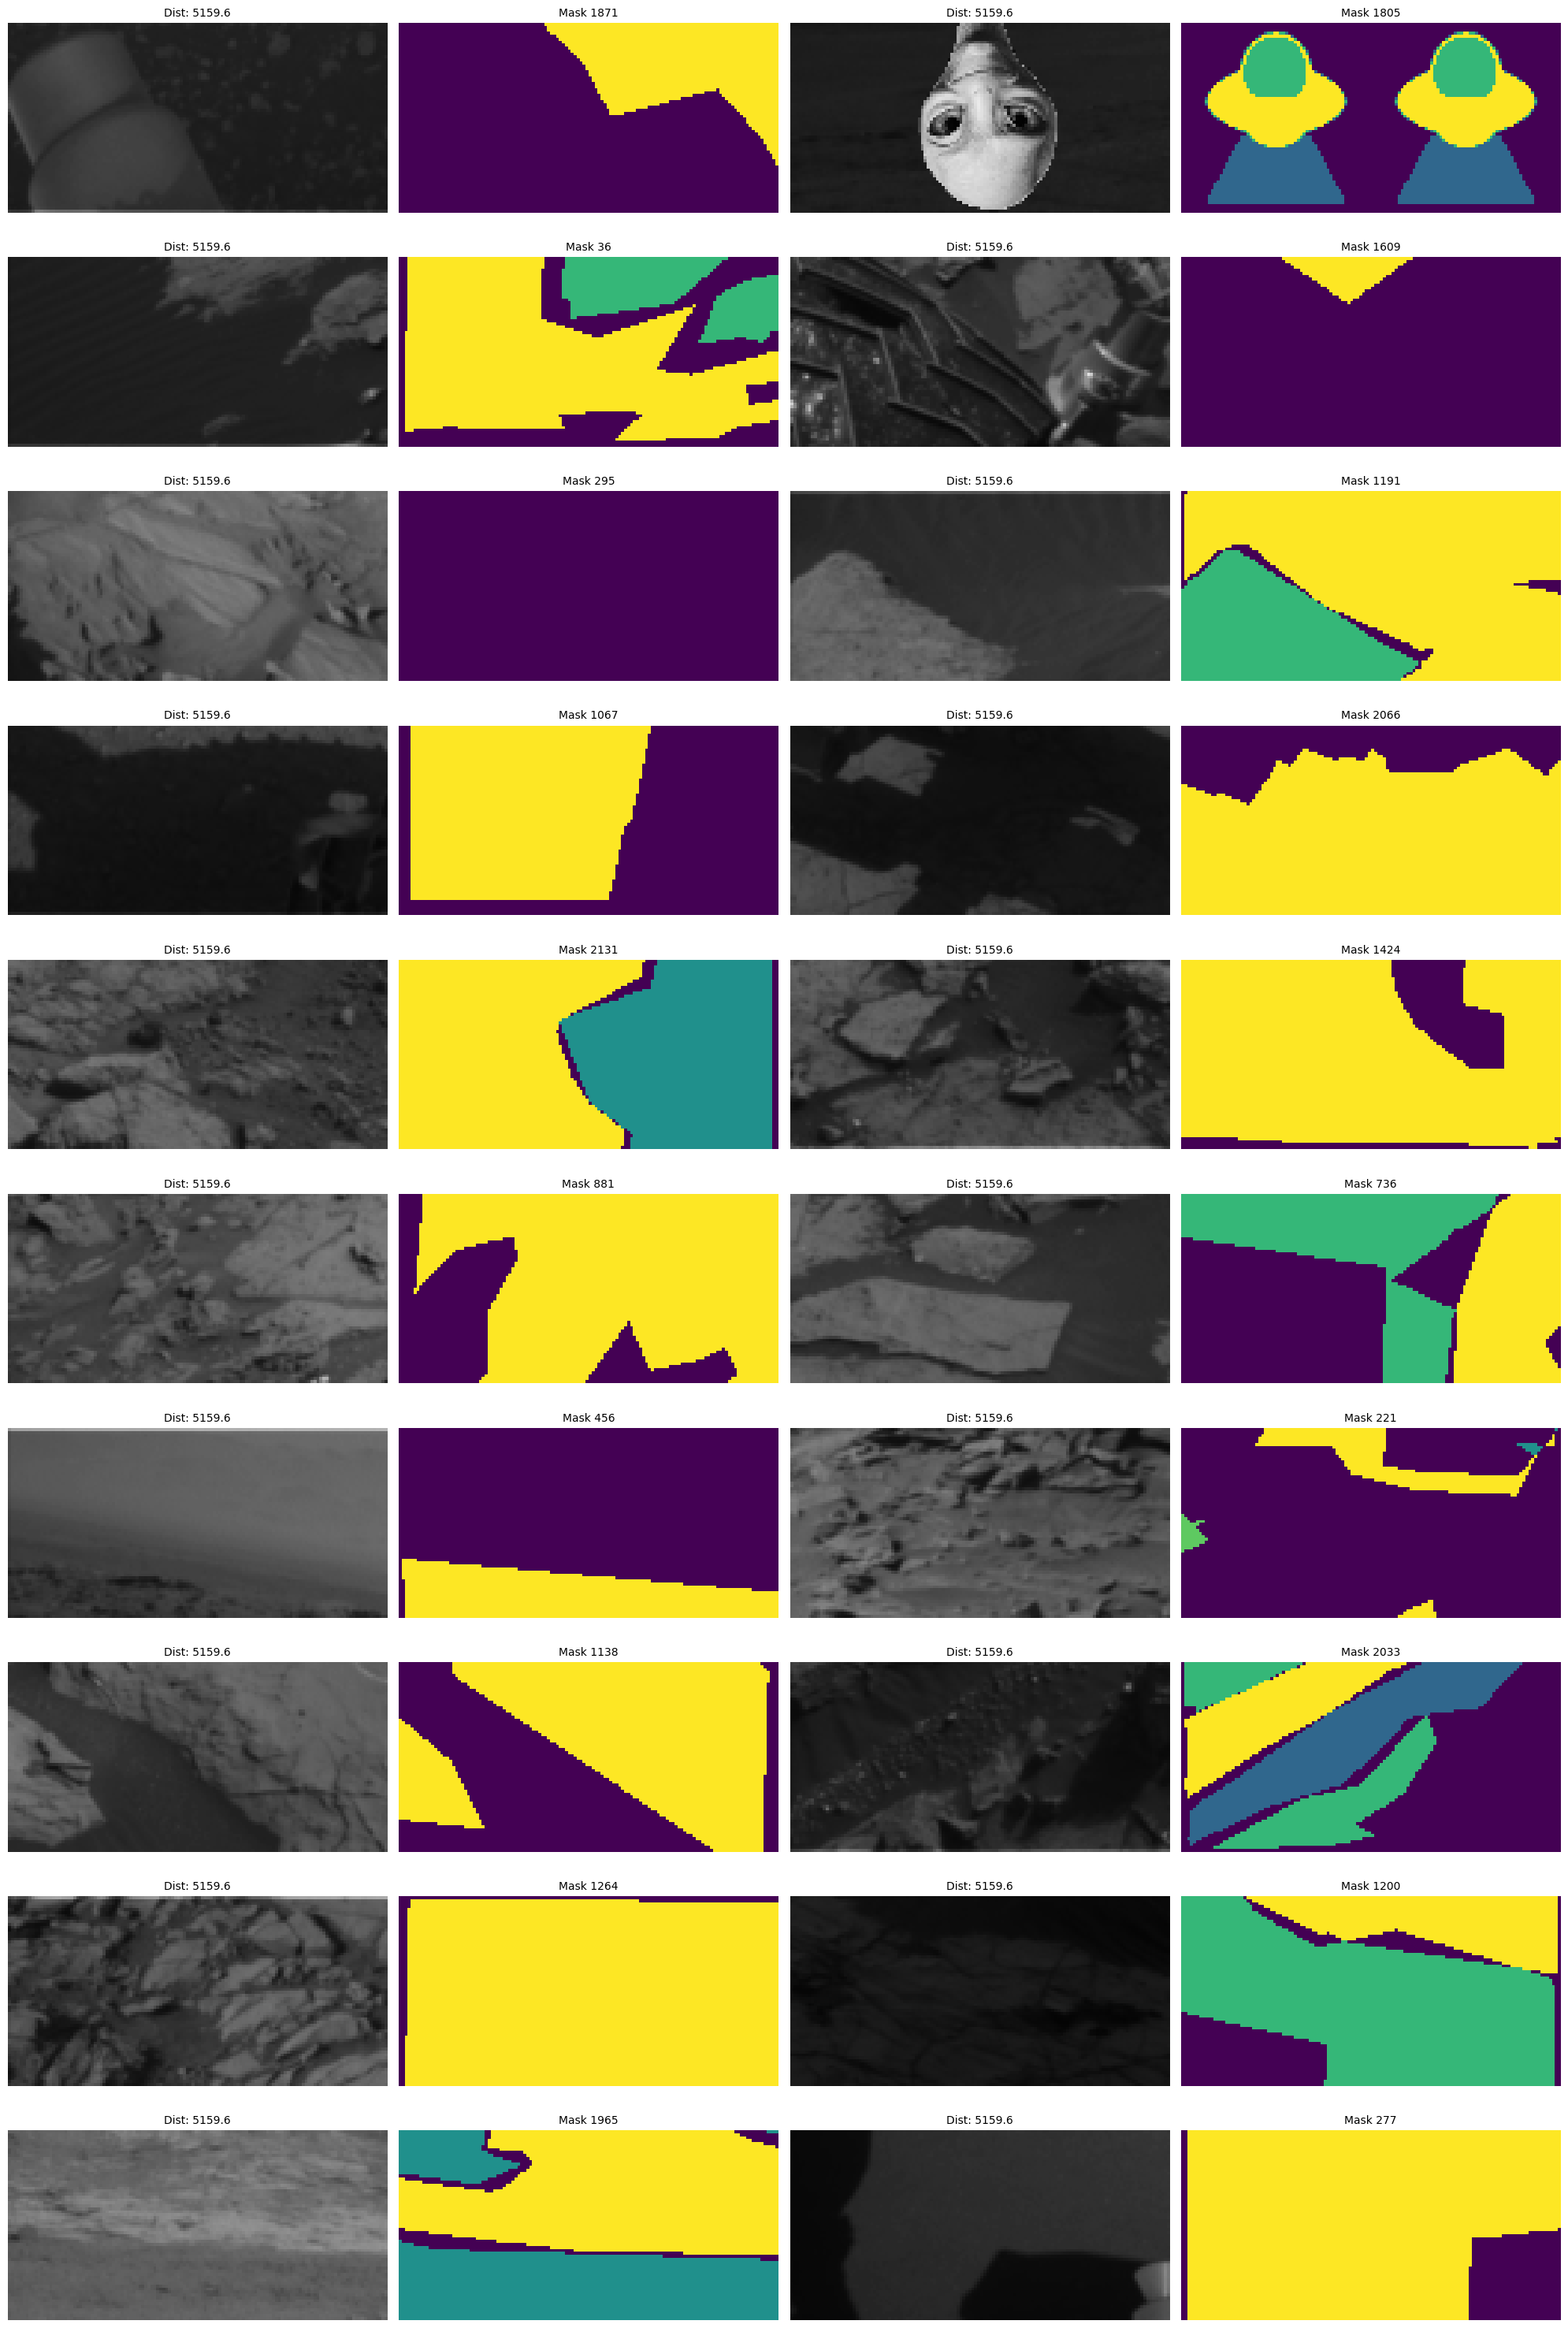

In [170]:
# Get indices of points outside of cluster 0
non_cluster_0_indices = np.where(clusters != 0)[0]

# Select 20 random indices from these points
random_indices = np.random.choice(non_cluster_0_indices, size=20, replace=False)

# Create a figure to display the images and masks
figure = plt.figure(figsize=(20, 30))

# Create a grid for the figure: 10 rows x 4 columns, then flatten the axes
axes_array = figure.subplots(10, 4)
axes_array = axes_array.flatten()

# Loop through the selected indices and display the images and masks
for i, index in enumerate(random_indices):
    # Display the input image
    axes_array[i * 2].imshow(input_images_clean[index], cmap='gray', vmin=0, vmax=255)
    axes_array[i * 2].axis('off')
    axes_array[i * 2].set_title(f'Dist: {round(distances[idx], 1)}', fontsize=10)
    
    # Display the corresponding mask
    axes_array[i * 2 + 1].imshow(output_masks_clean[index], cmap='viridis')
    axes_array[i * 2 + 1].axis('off')
    axes_array[i * 2 + 1].set_title(f'Mask {index}', fontsize=10)

plt.tight_layout()
plt.show()

One last time due to the alien here

In [171]:
# keep only the clean samples from x and y
input_images_clean = np.delete(input_images_clean, non_cluster_0_indices, axis=0)
output_masks_clean = np.delete(output_masks_clean, non_cluster_0_indices, axis=0)

input_images_clean.shape, output_masks_clean.shape

((2102, 64, 128), (2102, 64, 128))

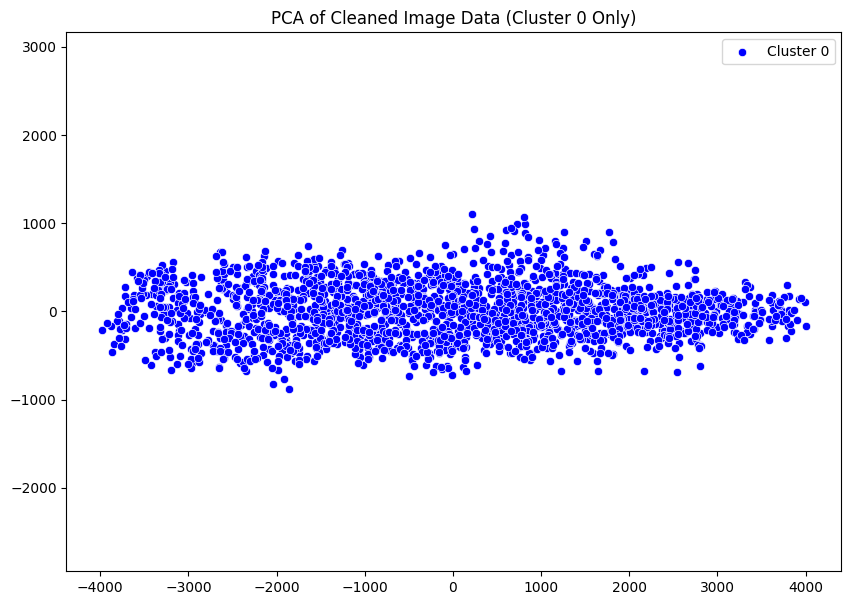

In [172]:
# Recompute PCA on the cleaned data
x_flat_clean = input_images_clean.reshape(input_images_clean.shape[0], -1)
features_pca_clean = pca.fit_transform(x_flat_clean)

# Plot the PCA result for the cleaned dataset
plt.figure(figsize=(10, 7))
plt.title('PCA of Cleaned Image Data (Cluster 0 Only)')
plt.axis('equal')

sns.scatterplot(x=features_pca_clean[:, 0], y=features_pca_clean[:, 1], label='Cluster 0', color='blue')

# Add legend
plt.legend()
plt.show()

Much better!

In [173]:
# Combine cleaned input images and masks into the same format as training_set
training_set_clean = np.stack((input_images_clean, output_masks_clean), axis=1)

# Save the cleaned data in the same format
output_path = "/kaggle/working/mars_for_students_cleaned.npz"
np.savez(output_path, training_set=training_set_clean, test_set=test_set)

print(f"Cleaned data saved to: {output_path}")

Cleaned data saved to: /kaggle/working/mars_for_students_cleaned.npz
